In [ ]:
#had to binarize subjects as the outputted oss-dbs vtas were not binarized!

In [ ]:
#binarized all the atlas structures- vim, vlpv, vldvlv, till
#till's has a threshold set at 50% or 0.45

In [1]:
import ants
import nilearn
from nilearn import image
import os
import shutil
import nibabel as nib
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from nilearn.image import load_img
from nilearn.image import math_img
from nilearn.image import resample_to_img
from nilearn.image import binarize_img
from nipype.interfaces.ants import ApplyTransforms
from scipy import stats
from scipy.stats import pearsonr
from scipy.stats import spearmanr

In [24]:
#resample hotspots
def resample(roi,vim,path):
    re_roi = resample_to_img(roi,vim,interpolation='nearest')
    nib.save(re_roi,path)
    
regions = ['VIM_distal','VLdVLv_ilinsky','VLpv_morel','dembek_drtt','neudorfer_hypointensity','neudorfer_nowacki_conjunction','nowacki_significance_map','tremor_vim_n39_hotspot']
mni = load_img('/Users/jp1590/Desktop/MNI152_T1_0.5mm.nii.gz')

for r in regions:
    lh = load_img(f'/Volumes/Cingulate/NativeMNI_Overlaps/EssentialTremor/HotspotsAtlas/{r}_lh.nii.gz')
    rh = load_img(f'/Volumes/Cingulate/NativeMNI_Overlaps/EssentialTremor/HotspotsAtlas/{r}_rh.nii.gz')
    resample(lh,mni,f'/Volumes/Cingulate/NativeMNI_Overlaps/EssentialTremor/HotspotsAtlas/resampled/{r}_hemi_L.nii.gz')
    resample(rh,mni,f'/Volumes/Cingulate/NativeMNI_Overlaps/EssentialTremor/HotspotsAtlas/resampled/{r}_hemi_R.nii.gz')

In [2]:
#converting MNI ROIs to each patient's native space- does not like special characters in paths, like &!!!!
def mni2native(i,hemisphere,hotspot,interpolation='NearestNeighbor'):
    print(f'converting to native for {i} in hotspot {hotspot}')
    at = ApplyTransforms()
    at.inputs.dimension = 3
    at.inputs.input_image = f'/Volumes/Cingulate/NativeMNI_Overlaps/EssentialTremor/HotspotsAtlas/resampled/{hotspot}_{hemisphere}.nii.gz'
    
    base_path = f'/Volumes/Cingulate/NativeMNI_Overlaps/EssentialTremor/Data/derivatives/leaddbs/{i}/coregistration/anat/{i}_ses-preop_space-anchorNative_desc-preproc_acq-'
    possible_files = ['ax_T1w.nii', 'cor_T1w.nii', 'iso_T1w.nii', 'ax_T2w.nii', 'iso_T2w.nii', 'sag_T1w.nii']
    
    reference_image = None
    for file_suffix in possible_files:
        ref_image_path = f'{base_path}{file_suffix}'
        if os.path.exists(ref_image_path):
            reference_image = ref_image_path
            break
        
    at.inputs.reference_image = reference_image
    at.inputs.transforms = f'/Volumes/Cingulate/NativeMNI_Overlaps/EssentialTremor/Data/derivatives/leaddbs/{i}/normalization/transformations/{i}_from-MNI152NLin2009bAsym_to-anchorNative_desc-ants.nii.gz'
    at.inputs.output_image = f'/Volumes/Cingulate/NativeMNI_Overlaps/EssentialTremor/OSS-DBS/{i}/{i}_{hotspot}_{hemisphere}_native_output.nii'
    at.inputs.invert_transform_flags = [False]
    at.inputs.interpolation = interpolation
    at.run()
    
directory = [i for i in os.listdir('/Volumes/Cingulate/NativeMNI_Overlaps/EssentialTremor/OSS-DBS') if i.startswith('sub')]
hotspots = ['neudorfer_hypointensity','neudorfer_nowacki_conjunction','nowacki_significance_map','tremor_vim_n39_hotspot','VIM_distal','VLdVLv_ilinsky','VLpv_morel']
hemispheres = ['hemi-L','hemi-R']

for i in directory:
    for hotspot in hotspots:
        for hemisphere in hemispheres:
            mni2native(i,hemisphere,hotspot)

converting to native for sub-02ad2 in hotspot dembek_drtt
converting to native for sub-02ad2 in hotspot dembek_drtt
converting to native for sub-0f0bf in hotspot dembek_drtt
converting to native for sub-0f0bf in hotspot dembek_drtt
converting to native for sub-10ae5 in hotspot dembek_drtt
converting to native for sub-10ae5 in hotspot dembek_drtt
converting to native for sub-13e41 in hotspot dembek_drtt
converting to native for sub-13e41 in hotspot dembek_drtt
converting to native for sub-1765d in hotspot dembek_drtt
converting to native for sub-1765d in hotspot dembek_drtt
converting to native for sub-17912 in hotspot dembek_drtt
converting to native for sub-17912 in hotspot dembek_drtt
converting to native for sub-18e53 in hotspot dembek_drtt
converting to native for sub-18e53 in hotspot dembek_drtt
converting to native for sub-1e506 in hotspot dembek_drtt
converting to native for sub-1e506 in hotspot dembek_drtt
converting to native for sub-265bd in hotspot dembek_drtt
converting to 

In [11]:
#binarize subjects
directory = [i for i in os.listdir('/Volumes/Cingulate/NativeMNI_Overlaps/EssentialTremor/OSS-DBS') if i.startswith('sub')]

for i in directory:
    lh = load_img(f'/Volumes/Cingulate/NativeMNI_Overlaps/EssentialTremor/OSS-DBS/{i}/stimulations/MNI152NLin2009bAsym/{i}_sim-binary_model-ossdbs_hemi-L.nii')
    rh = load_img(f'/Volumes/Cingulate/NativeMNI_Overlaps/EssentialTremor/OSS-DBS/{i}/stimulations/MNI152NLin2009bAsym/{i}_sim-binary_model-ossdbs_hemi-R.nii')
    bin_lh = binarize_img(lh)
    bin_rh = binarize_img(rh)
    nib.save(bin_lh,f'/Volumes/Cingulate/NativeMNI_Overlaps/EssentialTremor/OSS-DBS/{i}/stimulations/MNI152NLin2009bAsym/{i}_sim-binary_model-ossdbs_hemi-L.nii')
    nib.save(bin_rh,f'/Volumes/Cingulate/NativeMNI_Overlaps/EssentialTremor/OSS-DBS/{i}/stimulations/MNI152NLin2009bAsym/{i}_sim-binary_model-ossdbs_hemi-R.nii')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/nilearn/image/image.py:1065: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(niimg, result, niimg.affine)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/nilearn/image/image.py:1065: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(niimg, result, niimg.affine)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/nilearn/image/image.py

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/nilearn/image/image.py:1065: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(niimg, result, niimg.affine)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/nilearn/image/image.py:1065: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(niimg, result, niimg.affine)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/nilearn/image/image.py

In [12]:
#load, check for voxel dimensions, resample
directory = [i for i in os.listdir('/Volumes/Cingulate/NativeMNI_Overlaps/EssentialTremor/OSS-DBS') if i.startswith('sub')]

def dim(path):
    return nib.load(path).header.get_zooms()

def resample_binarize(sub,vim,output_path):
    sub = load_img(sub)
    vim = load_img(vim)
    re_sub = resample_to_img(sub,vim,interpolation='nearest')
    nib.save(re_sub,output_path)
    
def check4dims(sub_vox,vim_vox,sub,vim,output_path):
    if sub_vox == vim_vox:
        print('voxel dimensions the same')
    else:
        resample_binarize(sub,vim,output_path)

vim_mni = '/Volumes/Cingulate/NativeMNI_Overlaps/EssentialTremor/HotspotsAtlas/resampled/VIM_distal_hemi-L.nii.gz'
vim_mni_vox = dim(vim_mni)

for i in directory:
    print(i)
    vim_native = f'/Volumes/Cingulate/NativeMNI_Overlaps/EssentialTremor/OSS-DBS/{i}/{i}_VIM_distal_hemi-R_native_output.nii'
    vim_native_vox = dim(vim_native)
    
    native_lh = f'/Volumes/Cingulate/NativeMNI_Overlaps/EssentialTremor/OSS-DBS/{i}/stimulations/native/{i}_sim-binary_model-ossdbs_hemi-L.nii'
    native_rh = f'/Volumes/Cingulate/NativeMNI_Overlaps/EssentialTremor/OSS-DBS/{i}/stimulations/native/{i}_sim-binary_model-ossdbs_hemi-R.nii'
    native2mni_lh = f'/Volumes/Cingulate/NativeMNI_Overlaps/EssentialTremor/OSS-DBS/{i}/stimulations/native2MNI/{i}_sim-binary_model-ossdbs_hemi-L.nii'
    native2mni_rh = f'/Volumes/Cingulate/NativeMNI_Overlaps/EssentialTremor/OSS-DBS/{i}/stimulations/native2MNI/{i}_sim-binary_model-ossdbs_hemi-R.nii'
    mni_lh = f'/Volumes/Cingulate/NativeMNI_Overlaps/EssentialTremor/OSS-DBS/{i}/stimulations/MNI152NLin2009bAsym/{i}_sim-binary_model-ossdbs_hemi-L.nii'
    mni_rh = f'/Volumes/Cingulate/NativeMNI_Overlaps/EssentialTremor/OSS-DBS/{i}/stimulations/MNI152NLin2009bAsym/{i}_sim-binary_model-ossdbs_hemi-R.nii'

    native_lh_sub,native_rh_sub = load_img(native_lh),load_img(native_rh)
    native2mni_lh_sub,native2mni_rh_sub = load_img(native2mni_lh),load_img(native2mni_rh)
    mni_lh_sub,mni_rh_sub = load_img(mni_lh),load_img(mni_rh)
    
    native_lh_vox,native_rh_vox = dim(native_lh),dim(native_rh)
    native2mni_lh_vox,native2mni_rh_vox = dim(native2mni_lh),dim(native2mni_rh)
    mni_lh_vox,mni_rh_vox = dim(mni_lh),dim(mni_rh)
    
    check4dims(native_lh_vox,vim_native_vox,native_lh_sub,vim_native,f'/Volumes/Cingulate/NativeMNI_Overlaps/EssentialTremor/OSS-DBS/{i}/resampled/{i}_native_sim-binary_model-ossdbs_hemi-L.nii')
    check4dims(native_rh_vox,vim_native_vox,native_rh_sub,vim_native,f'/Volumes/Cingulate/NativeMNI_Overlaps/EssentialTremor/OSS-DBS/{i}/resampled/{i}_native_sim-binary_model-ossdbs_hemi-R.nii')
    check4dims(native2mni_lh_vox,vim_mni_vox,native2mni_lh_sub,vim_mni,f'/Volumes/Cingulate/NativeMNI_Overlaps/EssentialTremor/OSS-DBS/{i}/resampled/{i}_native2MNI_sim-binary_model-ossdbs_hemi-L.nii')
    check4dims(native2mni_rh_vox,vim_mni_vox,native2mni_rh_sub,vim_mni,f'/Volumes/Cingulate/NativeMNI_Overlaps/EssentialTremor/OSS-DBS/{i}/resampled/{i}_native2MNI_sim-binary_model-ossdbs_hemi-R.nii')
    check4dims(mni_lh_vox,vim_mni_vox,mni_lh_sub,vim_mni,f'/Volumes/Cingulate/NativeMNI_Overlaps/EssentialTremor/OSS-DBS/{i}/resampled/{i}_MNI_sim-binary_model-ossdbs_hemi-L.nii')
    check4dims(mni_rh_vox,vim_mni_vox,mni_rh_sub,vim_mni,f'/Volumes/Cingulate/NativeMNI_Overlaps/EssentialTremor/OSS-DBS/{i}/resampled/{i}_MNI_sim-binary_model-ossdbs_hemi-R.nii')

sub-02ad2
sub-0f0bf
sub-10ae5
sub-13e41
sub-1765d
sub-17912
sub-18e53
sub-1e506
sub-265bd
sub-30ed8
sub-3413f
sub-3c3ce
sub-49330
sub-4abbd
sub-544b6
sub-54b20
sub-59e15
sub-5dc03
sub-6b300
sub-6de35
sub-75381
sub-7b040
sub-7b793
sub-7ffd2
sub-8bc8e
sub-93d72
sub-a6331
sub-c01f1
sub-c2678
sub-c2a75
sub-c6f65
sub-cbd02
sub-d170a
sub-d9e29
sub-fea2f


In [13]:
#get volume of overlaps
directory = [i for i in os.listdir('/Volumes/Cingulate/NativeMNI_Overlaps/EssentialTremor/OSS-DBS') if i.startswith('sub')]
regions = ['VIM_distal','VLdVLv_ilinsky','VLpv_morel','dembek_drtt','neudorfer_hypointensity','neudorfer_nowacki_conjunction','nowacki_significance_map','tremor_vim_n39_hotspot']

#create dictionaries to store results
sub_ids = {'IDs': []}
native_overlap = {f'{r}_Native_Overlap_LH': [] for r in regions}
native_overlap.update({f'{r}_Native_Overlap_RH': [] for r in regions})
native_bilateral_overlap = {f'{r}_Native_Overlap_BI': [] for r in regions}
native_bilateral_mm = {f'{r}_Native_Overlap_BI_MM': [] for r in regions}
native2mni_overlap = {f'{r}_Native2MNI_Overlap_LH': [] for r in regions}
native2mni_overlap.update({f'{r}_Native2MNI_Overlap_RH': [] for r in regions})
native2mni_bilateral_overlap = {f'{r}_Native2MNI_Overlap_BI': [] for r in regions}
native2mni_bilateral_mm = {f'{r}_Native2MNI_Overlap_BI_MM': [] for r in regions}
mni_overlap = {f'{r}_MNI_Overlap_LH': [] for r in regions}
mni_overlap.update({f'{r}_MNI_Overlap_RH': [] for r in regions})
mni_bilateral_overlap = {f'{r}_MNI_Overlap_BI': [] for r in regions}
mni_bilateral_mm = {f'{r}_MNI_Overlap_BI_MM': [] for r in regions}
    
def get_binary_overlap(roi,sub,volume_list):
    mask = math_img('img1*img2',img1=roi,img2=sub)
    mask = mask.get_fdata()
    volume = np.sum(mask)
    volume_list.append(volume)
    
def binary_bilateral(list1,list2,sums_list):
    sums = [(x + y) for x, y in zip(list1, list2)]
    sums_list.extend(sums)
    
def convert(bi_list, vox, mm_list):
    for n in bi_list:
        mm = n * (vox[0] * vox[1] * vox[2])
        mm_list.append(mm)

for i in directory:
    for r in regions:
        roi_native_lh = load_img(f'/Volumes/Cingulate/NativeMNI_Overlaps/EssentialTremor/OSS-DBS/{i}/{i}_{r}_hemi-L_native_output.nii')
        roi_native_rh = load_img(f'/Volumes/Cingulate/NativeMNI_Overlaps/EssentialTremor/OSS-DBS/{i}/{i}_{r}_hemi-R_native_output.nii')
        roi_mni_lh = load_img(f'/Volumes/Cingulate/NativeMNI_Overlaps/EssentialTremor/HotspotsAtlas/resampled/{r}_hemi-L.nii.gz')
        roi_mni_rh = load_img(f'/Volumes/Cingulate/NativeMNI_Overlaps/EssentialTremor/HotspotsAtlas/resampled/{r}_hemi-R.nii.gz')
        
        sub_native_lh = load_img(f'/Volumes/Cingulate/NativeMNI_Overlaps/EssentialTremor/OSS-DBS/{i}/resampled/{i}_native_sim-binary_model-ossdbs_hemi-L.nii')
        sub_native_rh = load_img(f'/Volumes/Cingulate/NativeMNI_Overlaps/EssentialTremor/OSS-DBS/{i}/resampled/{i}_native_sim-binary_model-ossdbs_hemi-R.nii')
        sub_native2mni_lh = load_img(f'/Volumes/Cingulate/NativeMNI_Overlaps/EssentialTremor/OSS-DBS/{i}/resampled/{i}_native2MNI_sim-binary_model-ossdbs_hemi-L.nii')
        sub_native2mni_rh = load_img(f'/Volumes/Cingulate/NativeMNI_Overlaps/EssentialTremor/OSS-DBS/{i}/resampled/{i}_native2MNI_sim-binary_model-ossdbs_hemi-R.nii')
        sub_mni_lh = load_img(f'/Volumes/Cingulate/NativeMNI_Overlaps/EssentialTremor/OSS-DBS/{i}/resampled/{i}_MNI_sim-binary_model-ossdbs_hemi-L.nii')
        sub_mni_rh = load_img(f'/Volumes/Cingulate/NativeMNI_Overlaps/EssentialTremor/OSS-DBS/{i}/resampled/{i}_MNI_sim-binary_model-ossdbs_hemi-R.nii')

        get_binary_overlap(roi_native_lh,sub_native_lh,native_overlap[f'{r}_Native_Overlap_LH'])
        get_binary_overlap(roi_native_rh,sub_native_rh,native_overlap[f'{r}_Native_Overlap_RH'])
        get_binary_overlap(roi_mni_lh,sub_native2mni_lh,native2mni_overlap[f'{r}_Native2MNI_Overlap_LH'])
        get_binary_overlap(roi_mni_rh,sub_native2mni_rh,native2mni_overlap[f'{r}_Native2MNI_Overlap_RH'])
        get_binary_overlap(roi_mni_lh,sub_mni_lh,mni_overlap[f'{r}_MNI_Overlap_LH'])
        get_binary_overlap(roi_mni_rh,sub_mni_rh,mni_overlap[f'{r}_MNI_Overlap_RH'])
        
for r in regions:
    binary_bilateral(native_overlap[f'{r}_Native_Overlap_LH'], native_overlap[f'{r}_Native_Overlap_RH'], native_bilateral_overlap[f'{r}_Native_Overlap_BI'])
    binary_bilateral(native2mni_overlap[f'{r}_Native2MNI_Overlap_LH'], native2mni_overlap[f'{r}_Native2MNI_Overlap_RH'], native2mni_bilateral_overlap[f'{r}_Native2MNI_Overlap_BI'])
    binary_bilateral(mni_overlap[f'{r}_MNI_Overlap_LH'], mni_overlap[f'{r}_MNI_Overlap_RH'], mni_bilateral_overlap[f'{r}_MNI_Overlap_BI'])
    
native_vox_dims = sub_native_lh.header.get_zooms()
native2mni_vox_dims = sub_native2mni_lh.header.get_zooms()
mni_vox_dims = sub_mni_lh.header.get_zooms()

for r in regions:
    convert(native_bilateral_overlap[f'{r}_Native_Overlap_BI'], native_vox_dims, native_bilateral_mm[f'{r}_Native_Overlap_BI_MM'])
    convert(native2mni_bilateral_overlap[f'{r}_Native2MNI_Overlap_BI'], native2mni_vox_dims, native2mni_bilateral_mm[f'{r}_Native2MNI_Overlap_BI_MM'])
    convert(mni_bilateral_overlap[f'{r}_MNI_Overlap_BI'], mni_vox_dims, mni_bilateral_mm[f'{r}_MNI_Overlap_BI_MM'])
    
for i in directory:
    sub_ids['IDs'].append(i)

ids_df = pd.DataFrame.from_dict(sub_ids, orient='index').transpose()
native_df = pd.DataFrame.from_dict(native_overlap, orient='index').transpose()
native_bilateral_df = pd.DataFrame.from_dict(native_bilateral_overlap, orient='index').transpose()
native_bilateral_mm_df = pd.DataFrame.from_dict(native_bilateral_mm, orient='index').transpose()
native2mni_df = pd.DataFrame.from_dict(native2mni_overlap, orient='index').transpose()
native2mni_bilateral_df = pd.DataFrame.from_dict(native2mni_bilateral_overlap, orient='index').transpose()
native2mni_bilateral_mm_df = pd.DataFrame.from_dict(native2mni_bilateral_mm, orient='index').transpose()
mni_df = pd.DataFrame.from_dict(mni_overlap, orient='index').transpose()
mni_bilateral_df = pd.DataFrame.from_dict(mni_bilateral_overlap, orient='index').transpose()
mni_bilateral_mm_df = pd.DataFrame.from_dict(mni_bilateral_mm, orient='index').transpose()

combined_df = pd.concat([ids_df,native_df, native_bilateral_df, native_bilateral_mm_df,native2mni_df, native2mni_bilateral_df, native2mni_bilateral_mm_df,mni_df, mni_bilateral_df, mni_bilateral_mm_df], axis=1, keys=['IDs','Native', 'Native_Bilateral', 'Native_Bilateral_mm','Native2MNI', 'Native2MNI_Bilateral', 'Native2MNI_Bilateral_mm','MNI', 'MNI_Bilateral', 'MNI_Bilateral_mm'])

combined_df.to_csv('/Volumes/Cingulate/NativeMNI_Overlaps/EssentialTremor/new_OSS-DBS_Volume_Overlaps.csv', index=False)

# Plots

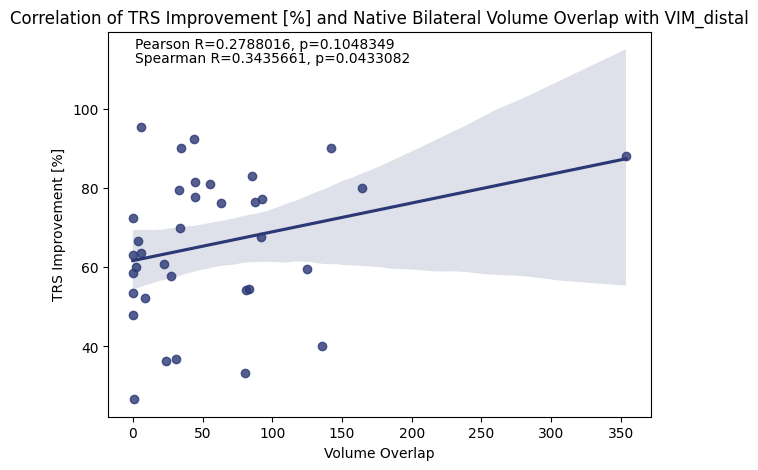

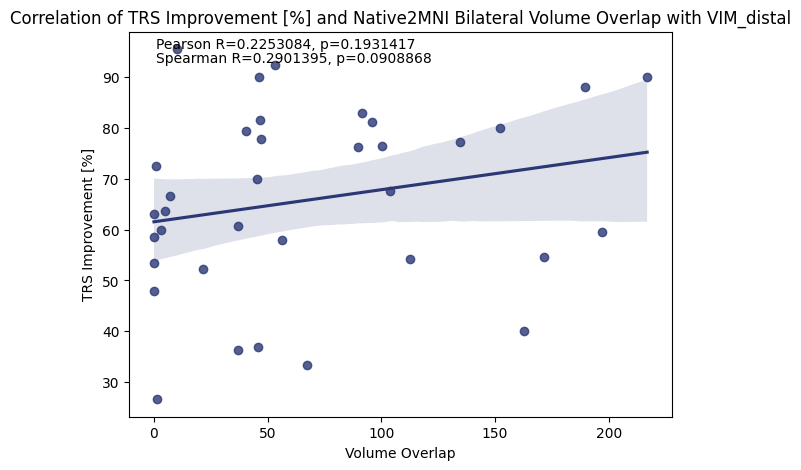

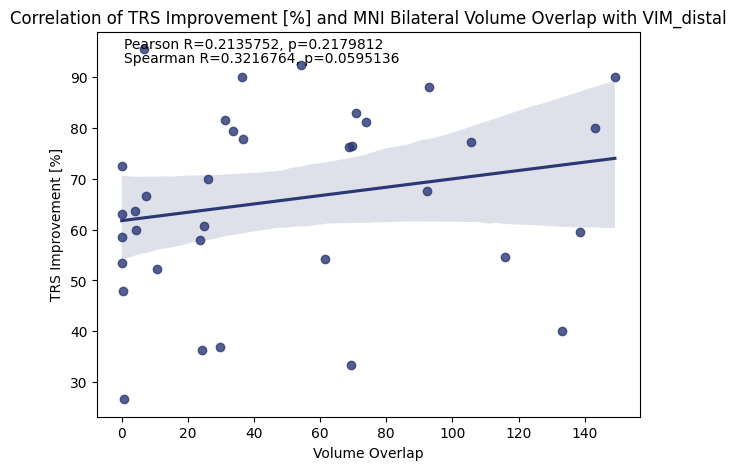

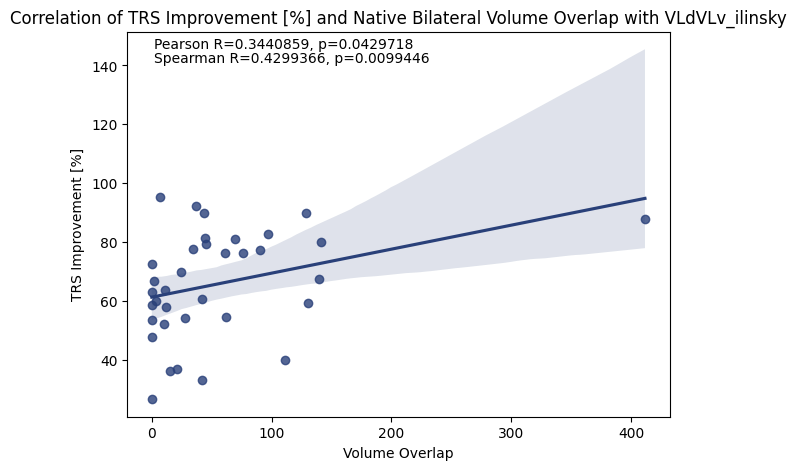

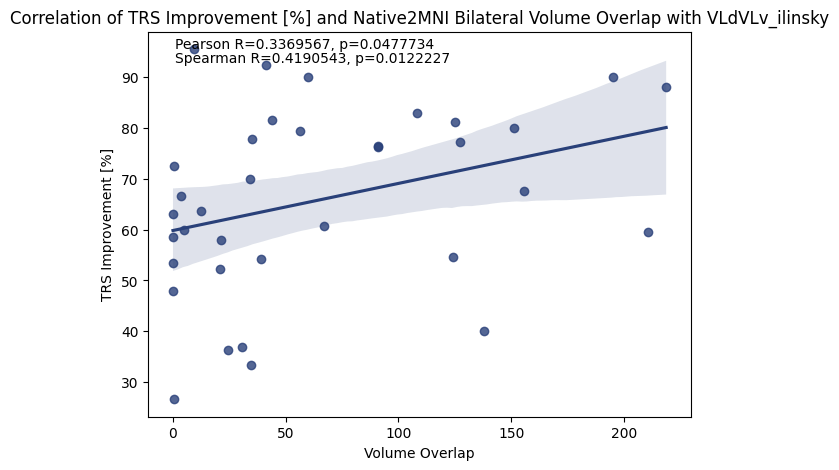

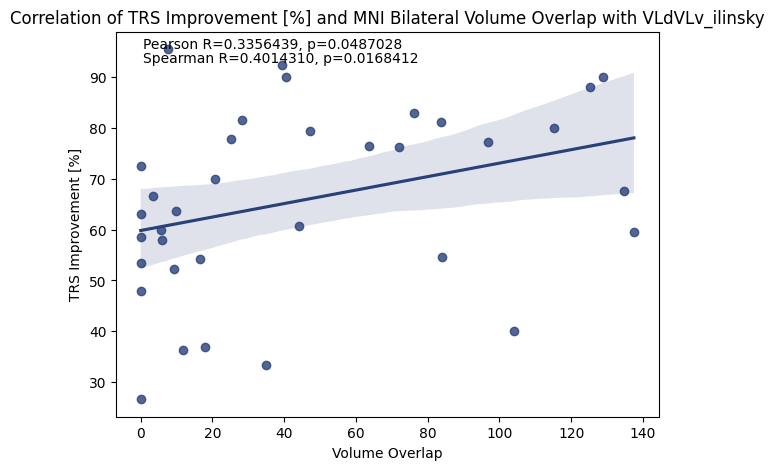

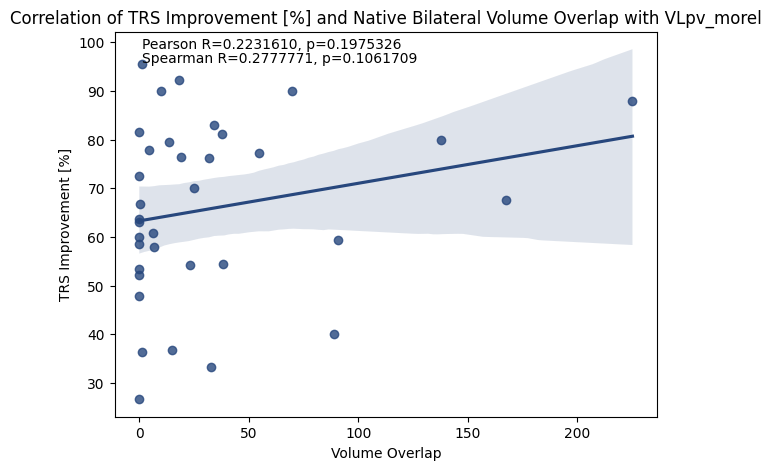

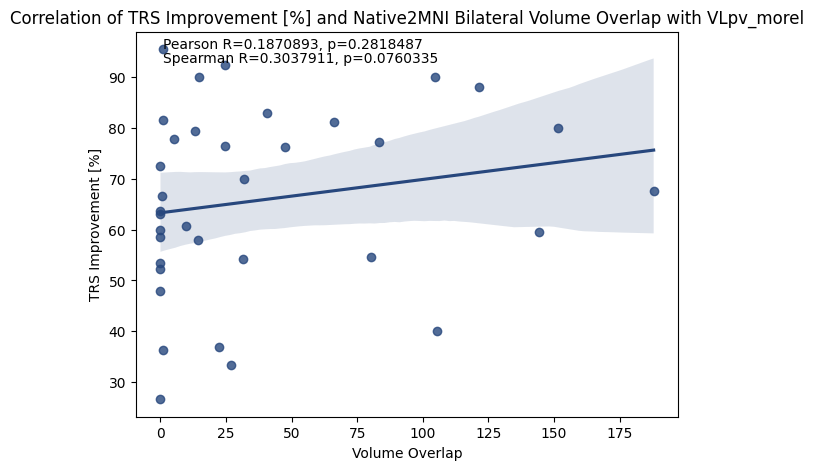

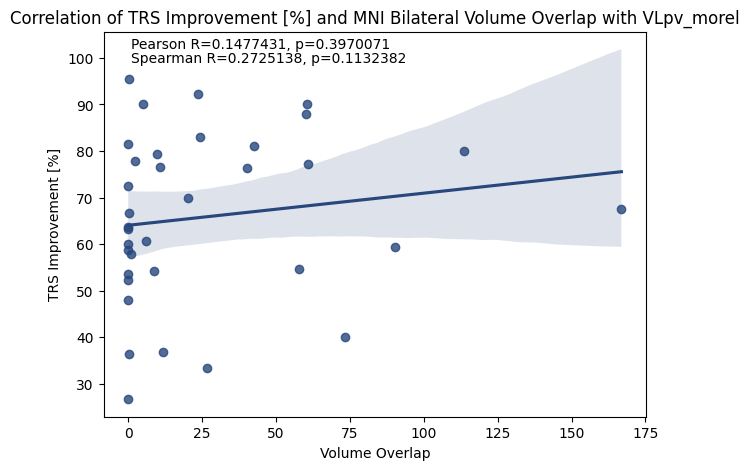

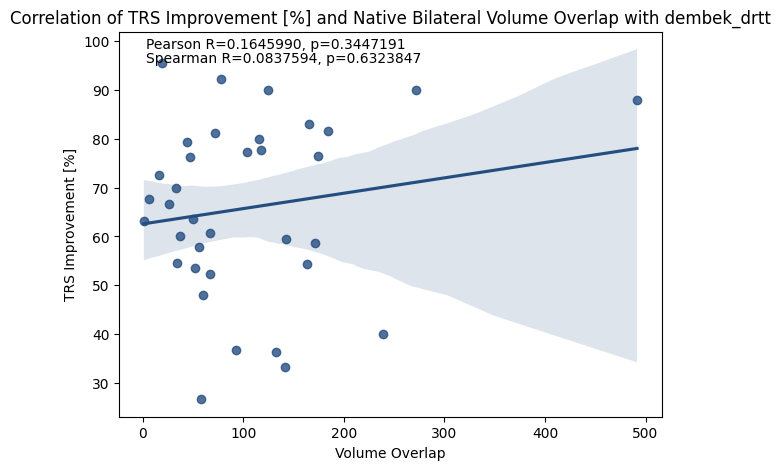

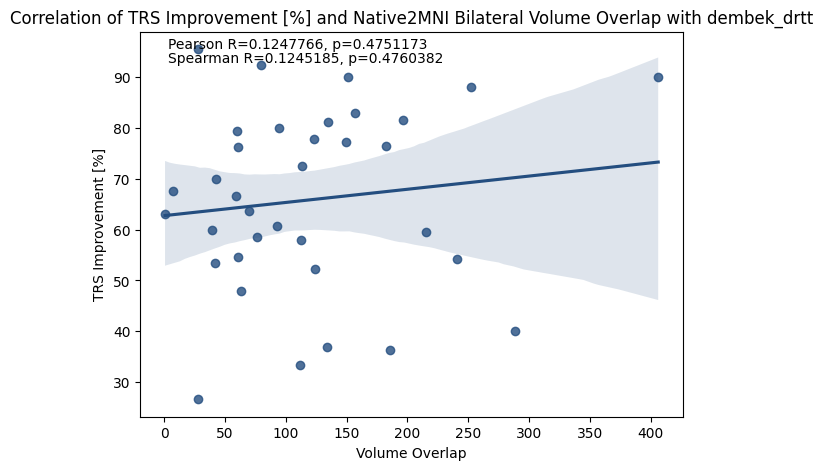

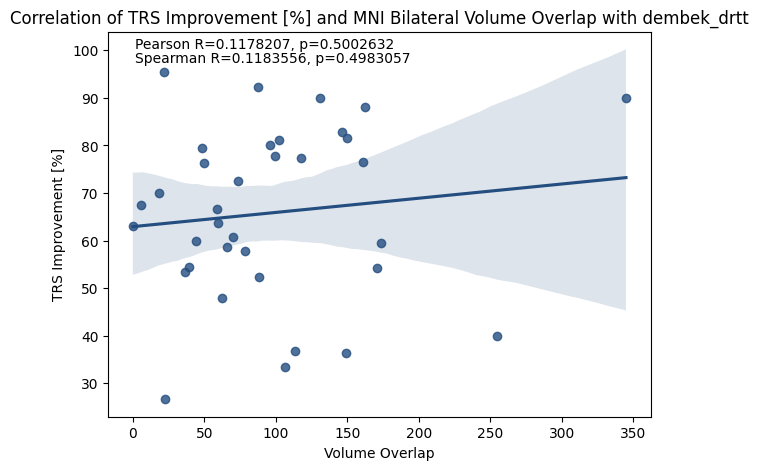

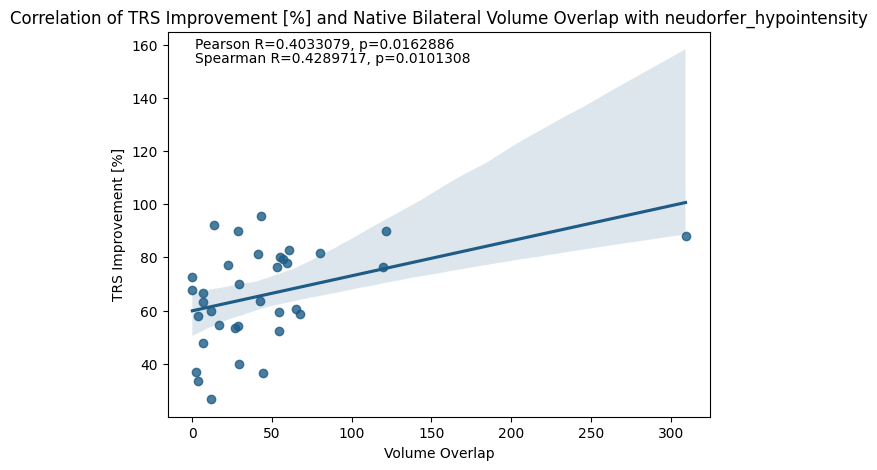

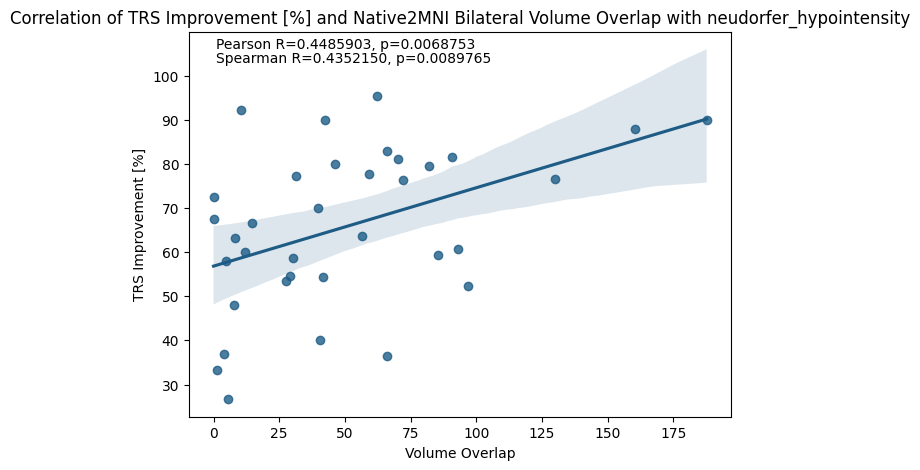

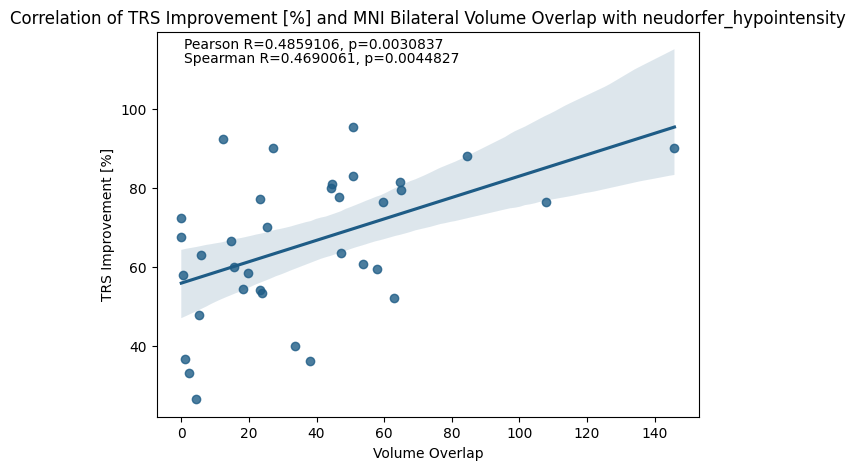

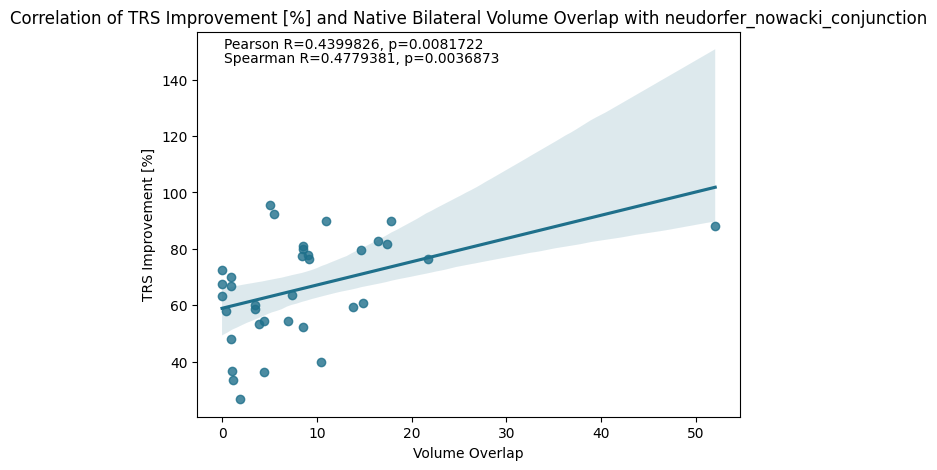

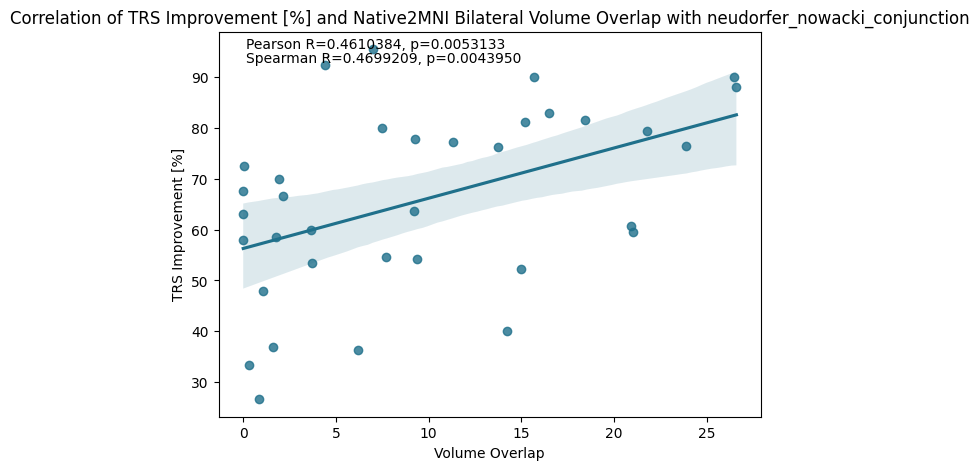

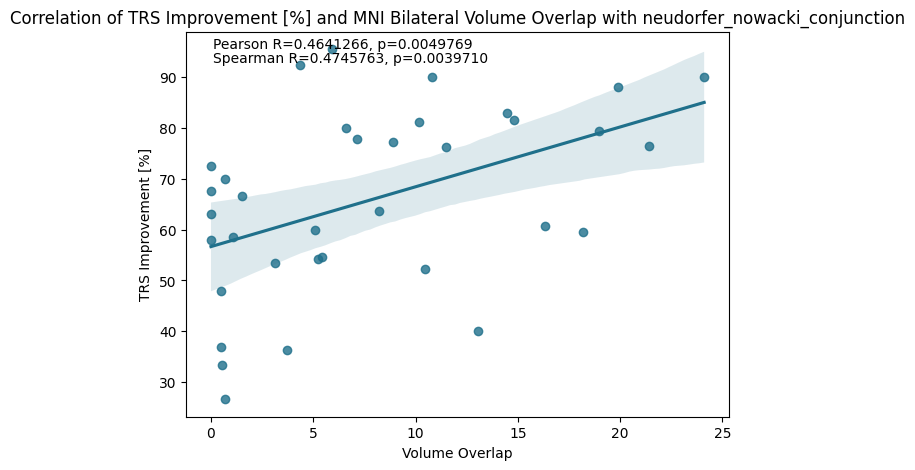

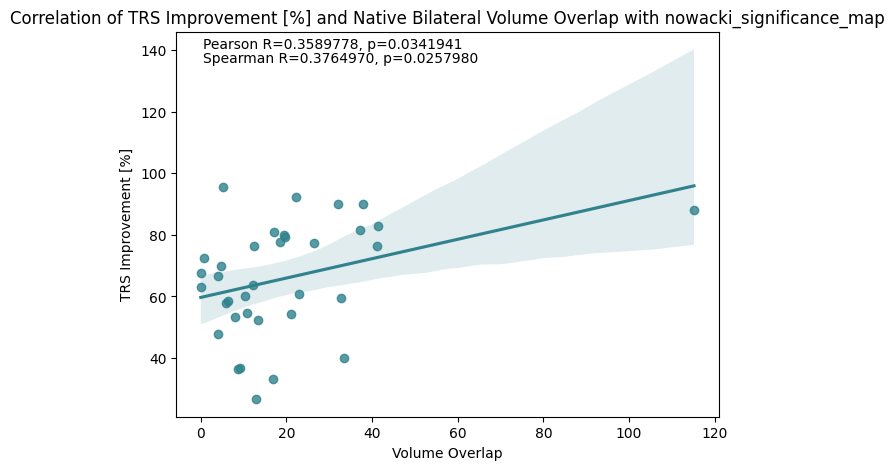

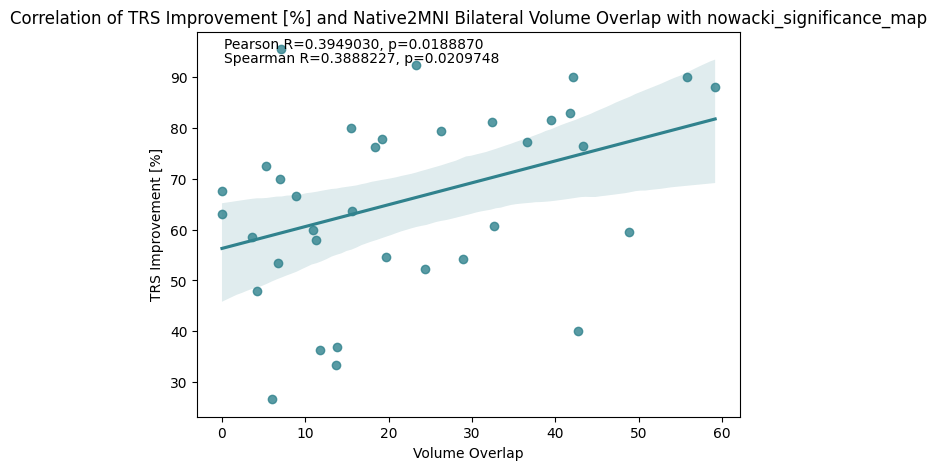

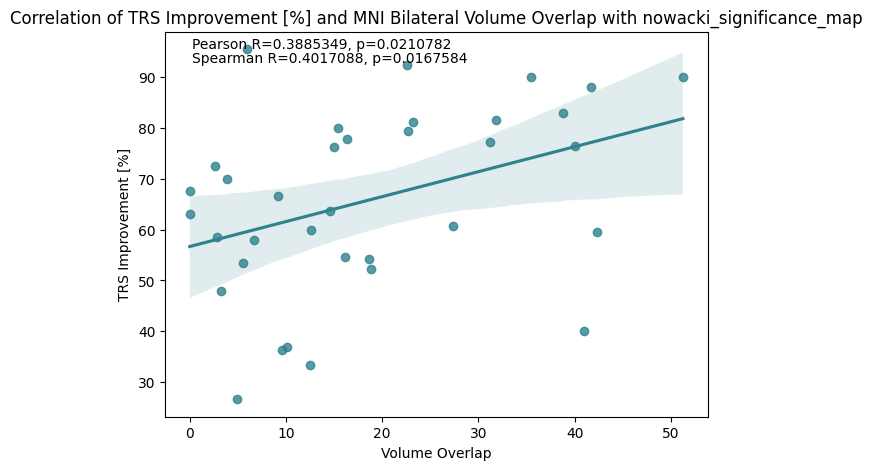

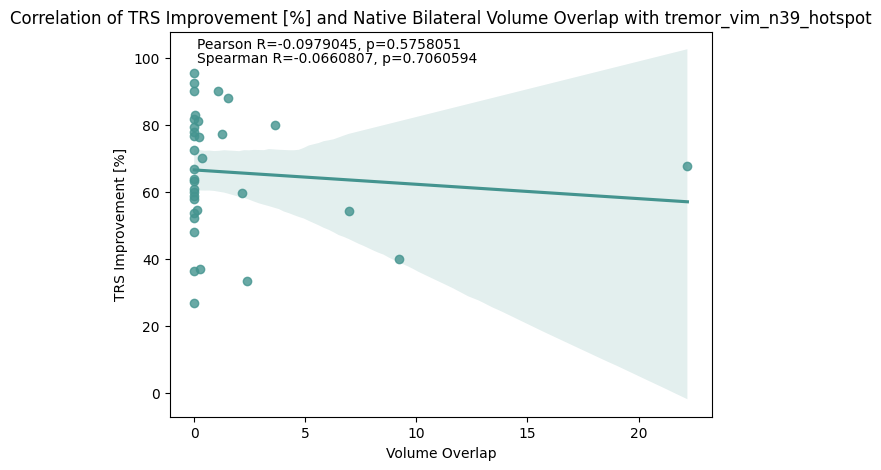

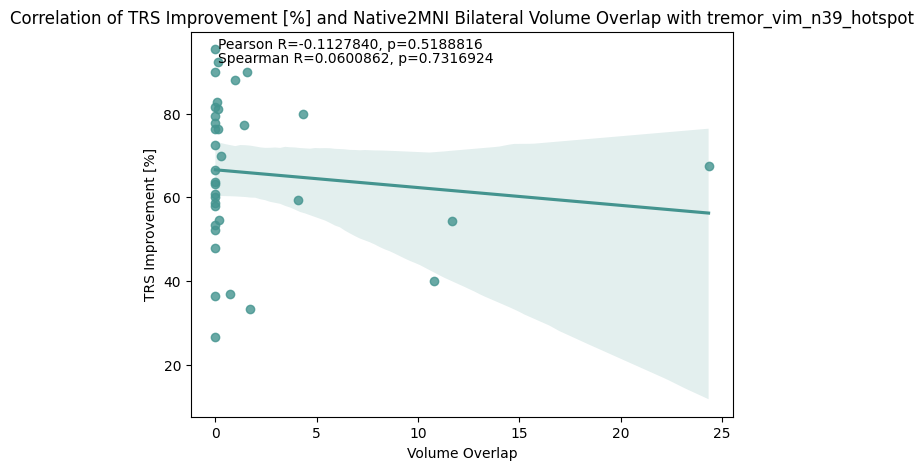

In [ ]:
#oss-dbs
df = pd.read_csv('/Volumes/Cingulate/NativeMNI_Overlaps/EssentialTremor/Figures/csv/OSS-DBS_Volume_Overlaps.csv')
colors = ['#2b3875','#294079','#27477d','#244e80','#1e5c86','#1f708b','#30828d','#44948f']
regions = ['VIM_distal','VLdVLv_ilinsky','VLpv_morel','dembek_drtt','neudorfer_hypointensity','neudorfer_nowacki_conjunction','nowacki_significance_map','tremor_vim_n39_hotspot']

def r_p(vol_overlap_col):
    pearson_r, pearson_p = pearsonr(df['TRS_Perc_Improvement'],df[vol_overlap_col])
    spearman_r, spearman_p = spearmanr(df['TRS_Perc_Improvement'],df[vol_overlap_col])
    return pearson_r, pearson_p, spearman_r, spearman_p

def plot_analysis(x_data, title, pearson_r_val, pearson_p_val, spearman_r_val, spearman_p_val, color,path):
    plt.figure(figsize=(7, 5))
    ax = sns.regplot(x=x_data, y=df['TRS_Perc_Improvement'], color=color)
    plt.title(title)
    plt.xlabel('Volume Overlap')
    plt.ylabel('TRS Improvement [%]')
    ax.text(0.05, 0.95, 'Pearson R={:.7f}, p={:.7f}'.format(pearson_r_val, pearson_p_val),transform=ax.transAxes, verticalalignment='bottom')
    ax.text(0.05, 0.95, 'Spearman R={:.7f}, p={:.7f}'.format(spearman_r_val, spearman_p_val),transform=ax.transAxes, verticalalignment='top')
    plt.savefig(path)
    plt.show()
    
for c, r in enumerate(regions):
    color = colors[c % len(colors)]
    native_pearson_r,native_pearson_p,native_spearman_r,native_spearman_p = r_p(f'{r}_Native_Overlap_BI_MM')
    native2mni_pearson_r,native2mni_pearson_p,native2mni_spearman_r,native2mni_spearman_p = r_p(f'{r}_Native2MNI_Overlap_BI_MM')
    mni_pearson_r,mni_pearson_p,mni_spearman_r,mni_spearman_p = r_p(f'{r}_MNI_Overlap_BI_MM')
    plot_analysis(df[f'{r}_Native_Overlap_BI_MM'],f'Correlation of TRS Improvement [%] and Native Bilateral Volume Overlap with {r}',native_pearson_r,native_pearson_p,native_spearman_r,native_spearman_p,color,f'/Volumes/Cingulate/NativeMNI_Overlaps/EssentialTremor/Figures/OSS-DBS/Native Correlation Bilateral Volume Overlap with {r}.png')
    plot_analysis(df[f'{r}_Native2MNI_Overlap_BI_MM'],f'Correlation of TRS Improvement [%] and Native2MNI Bilateral Volume Overlap with {r}',native2mni_pearson_r,native2mni_pearson_p,native2mni_spearman_r,native2mni_spearman_p,color,f'/Volumes/Cingulate/NativeMNI_Overlaps/EssentialTremor/Figures/OSS-DBS/Native2MNI Correlation Bilateral Volume Overlap with {r}.png')
    plot_analysis(df[f'{r}_MNI_Overlap_BI_MM'],f'Correlation of TRS Improvement [%] and MNI Bilateral Volume Overlap with {r}',mni_pearson_r,mni_pearson_p,mni_spearman_r,mni_spearman_p,color,f'/Volumes/Cingulate/NativeMNI_Overlaps/EssentialTremor/Figures/OSS-DBS/MNI Correlation Bilateral Volume Overlap with {r}.png')

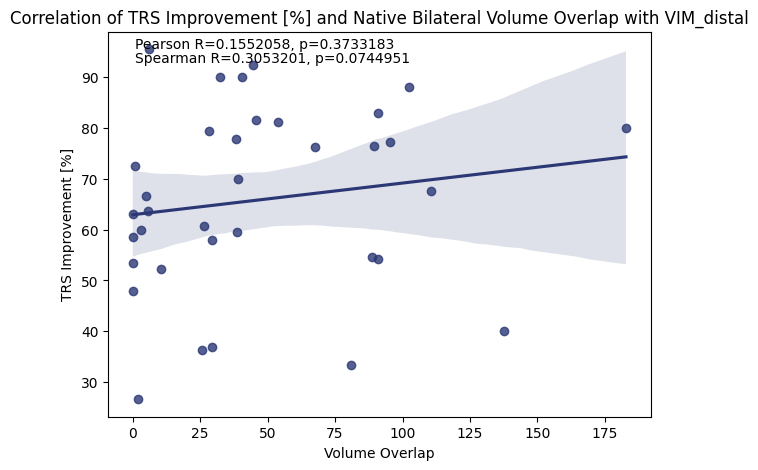

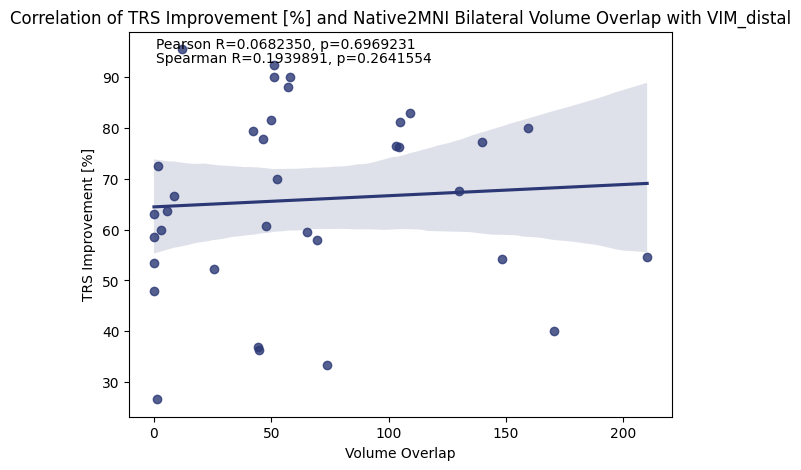

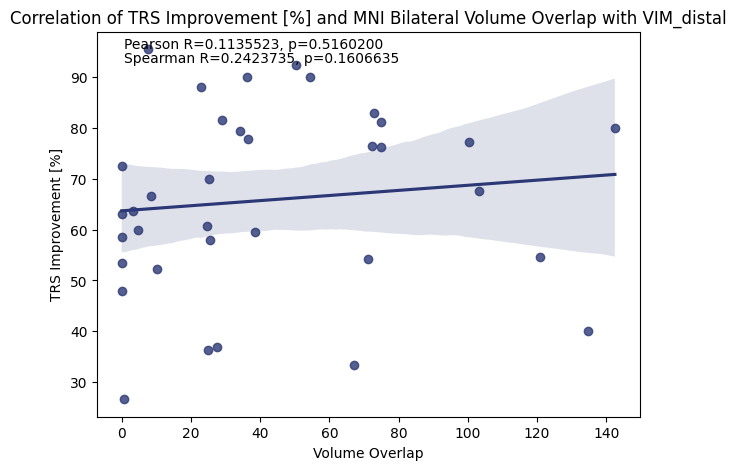

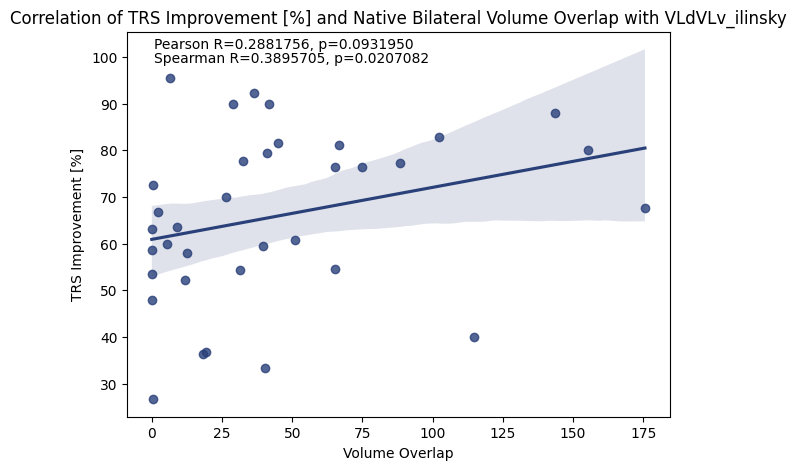

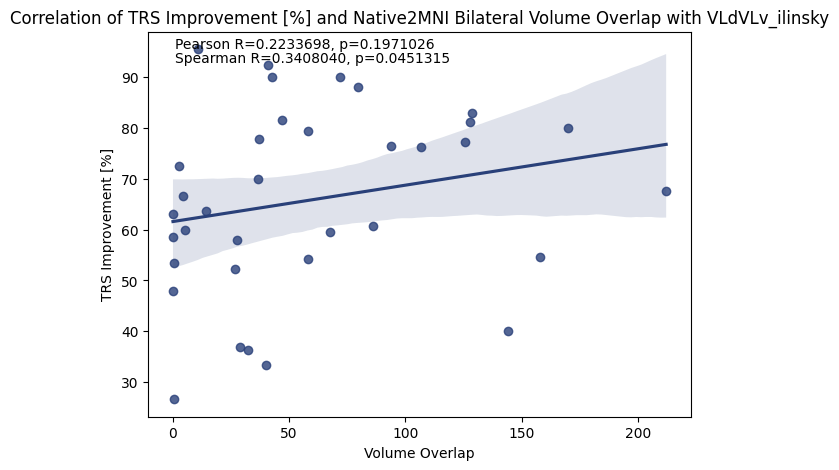

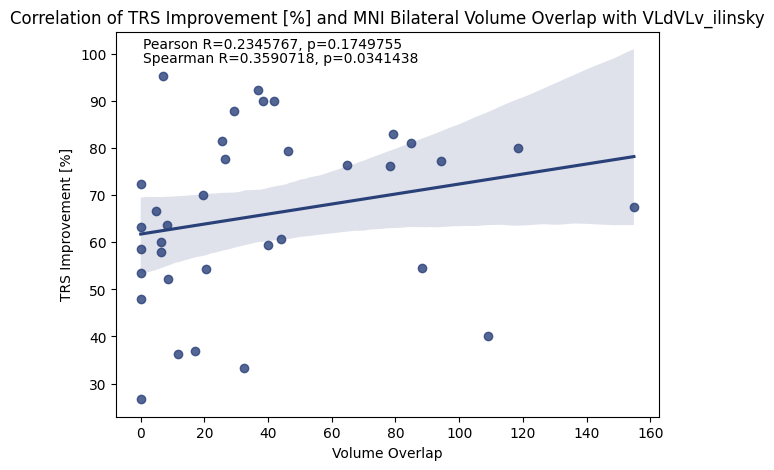

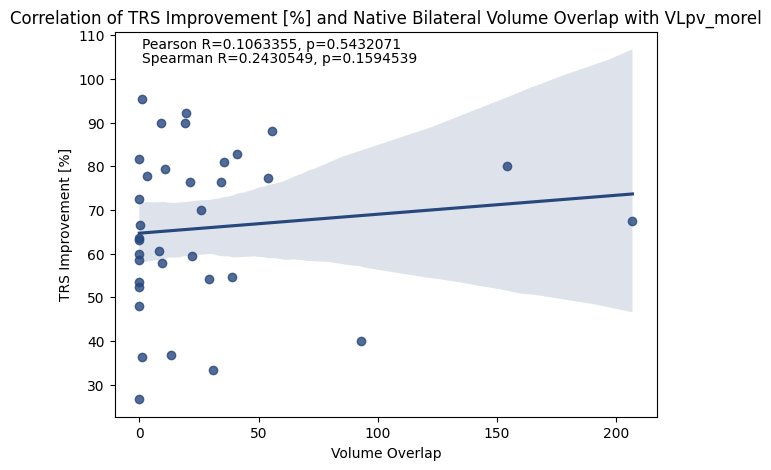

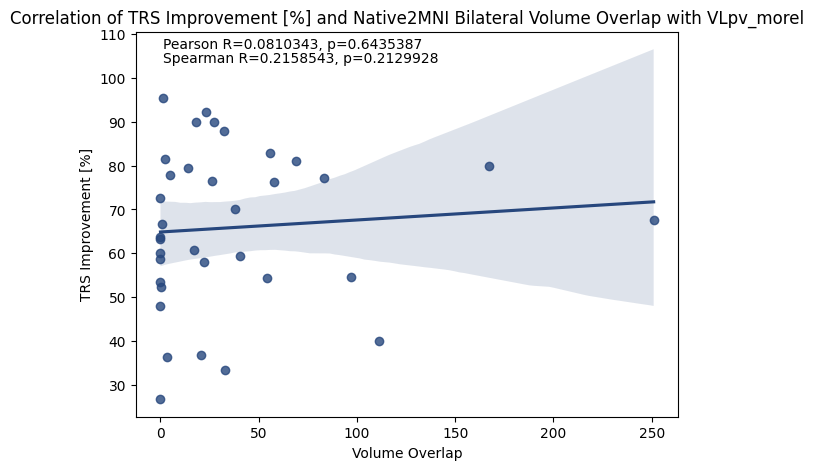

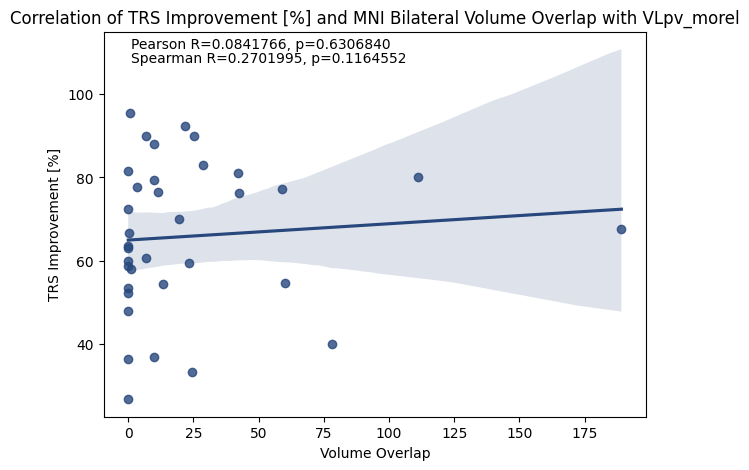

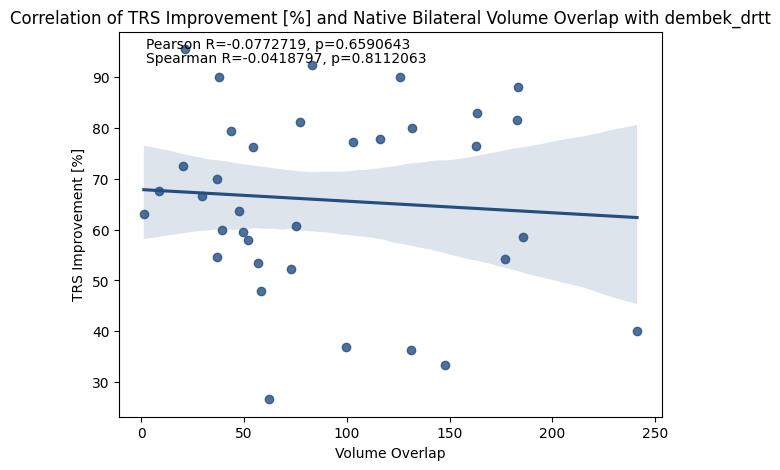

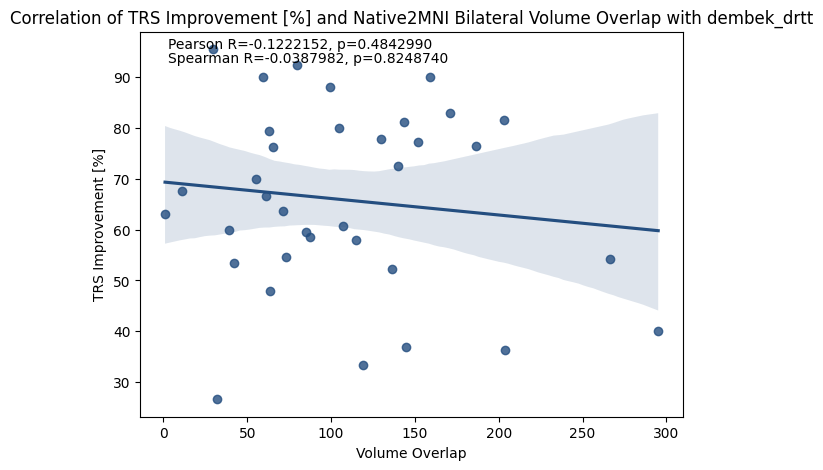

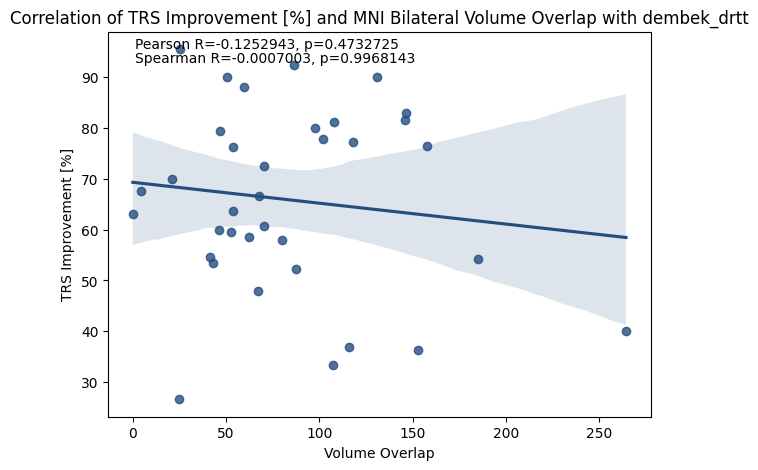

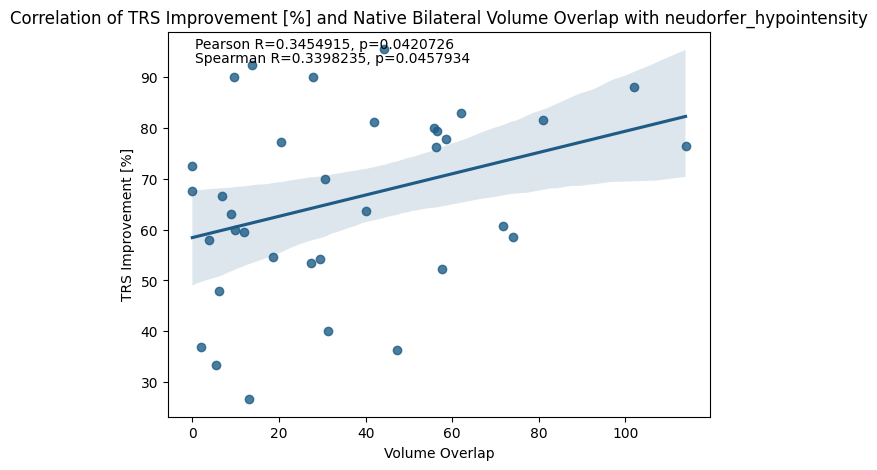

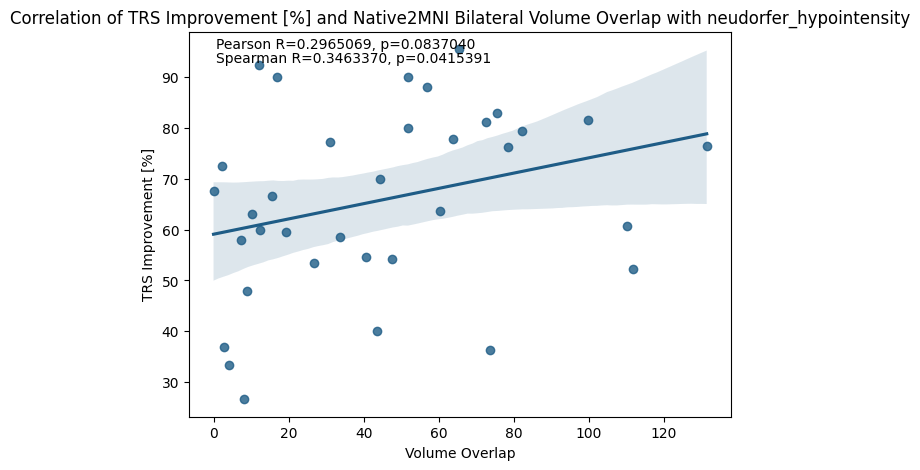

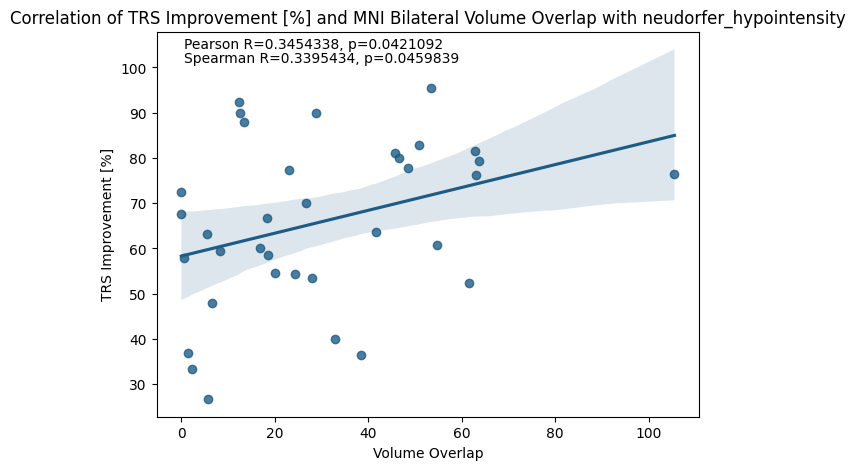

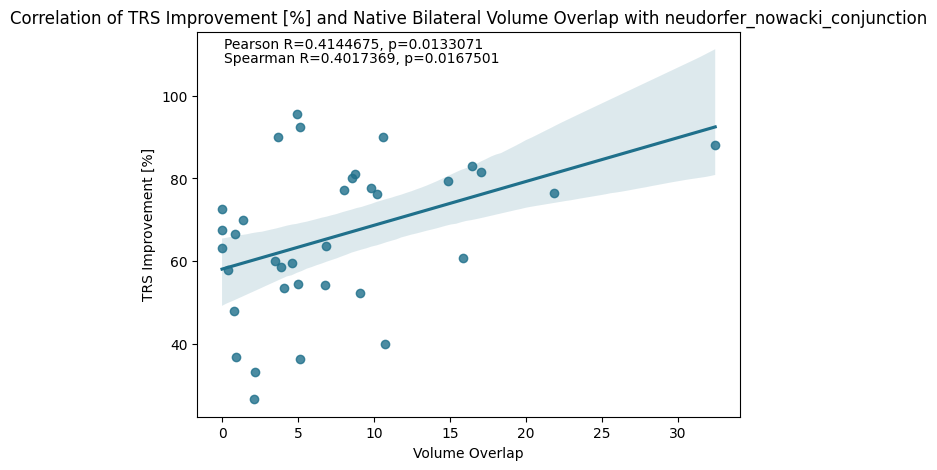

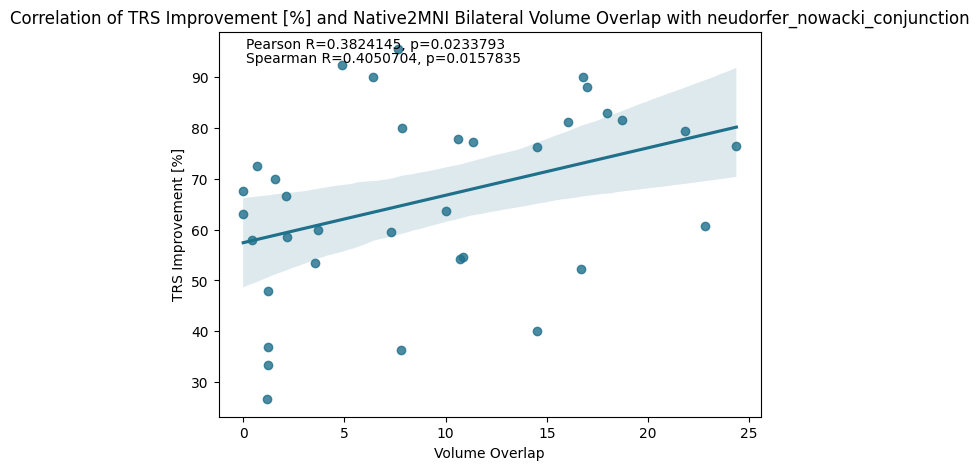

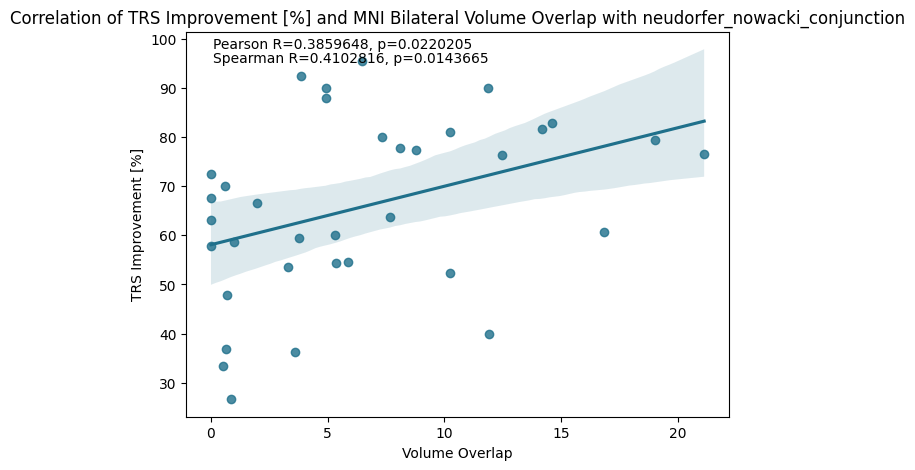

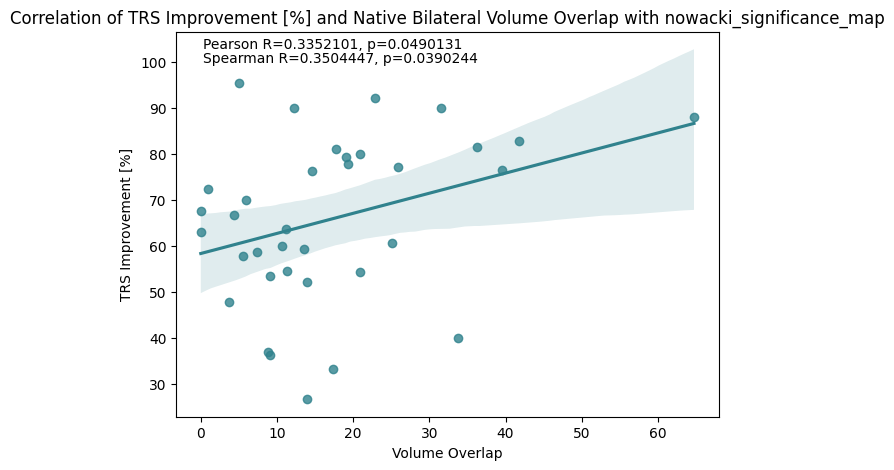

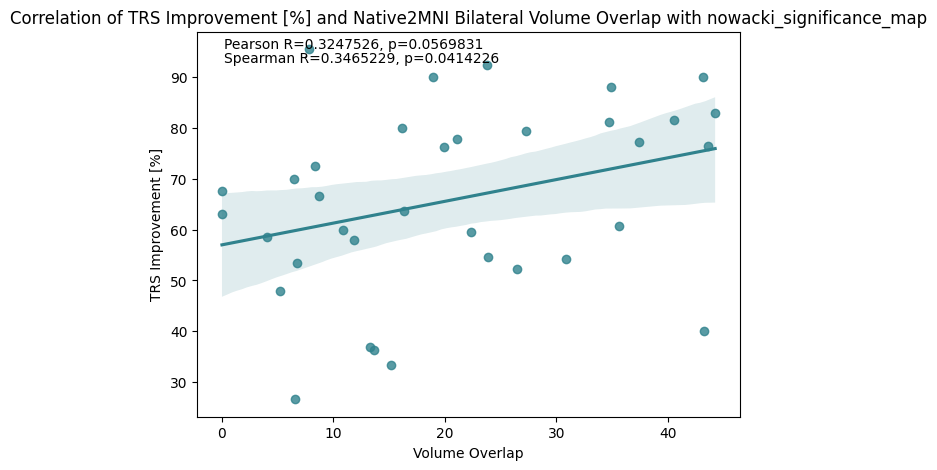

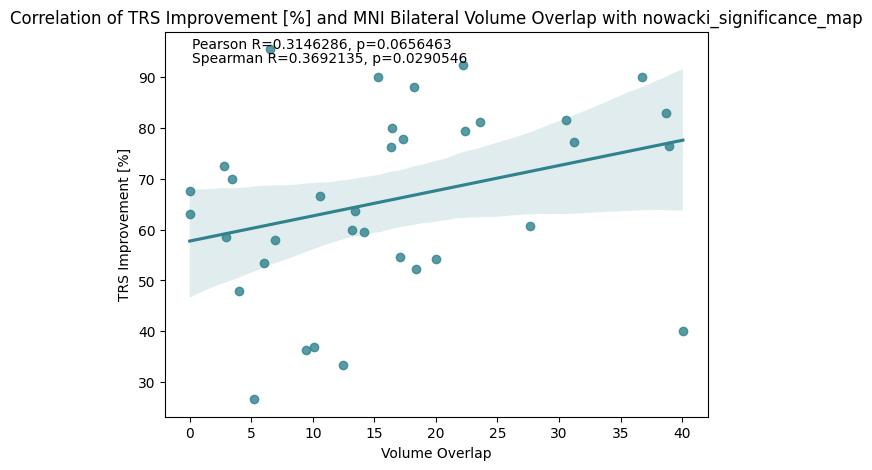

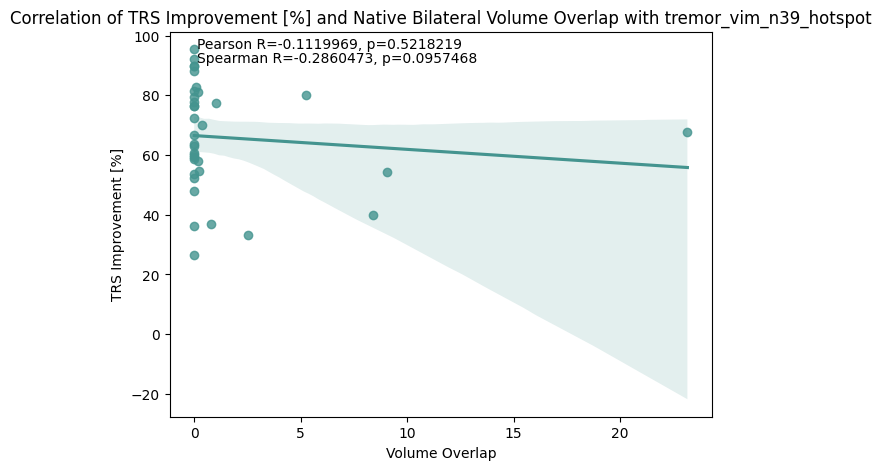

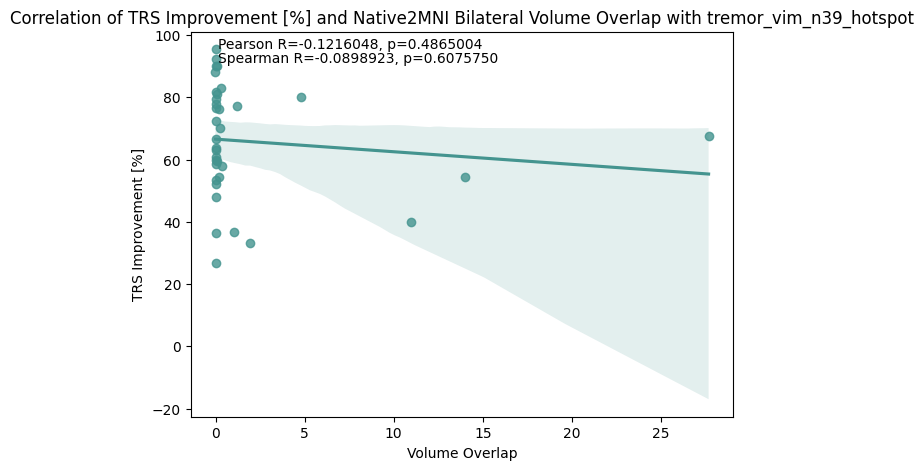

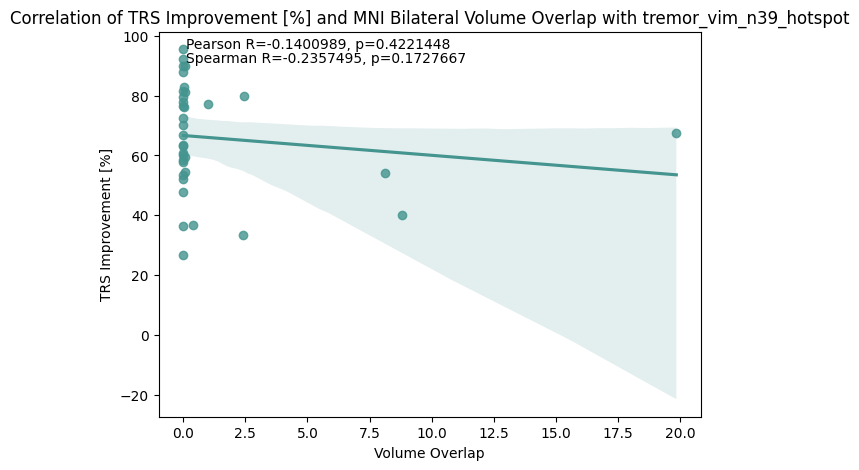

In [20]:
#fieldtrip
df = pd.read_csv('/Volumes/Cingulate/NativeMNI_Overlaps/EssentialTremor/new_FieldTrip_Volume_Overlaps.csv')
colors = ['#2b3875','#294079','#27477d','#244e80','#1e5c86','#1f708b','#30828d','#44948f']
regions = ['VIM_distal','VLdVLv_ilinsky','VLpv_morel','dembek_drtt','neudorfer_hypointensity','neudorfer_nowacki_conjunction','nowacki_significance_map','tremor_vim_n39_hotspot']

def r_p(vol_overlap_col):
    pearson_r, pearson_p = pearsonr(df['TRS_Perc_Improvement'],df[vol_overlap_col])
    spearman_r, spearman_p = spearmanr(df['TRS_Perc_Improvement'],df[vol_overlap_col])
    return pearson_r, pearson_p, spearman_r, spearman_p

def plot_analysis(x_data, title, pearson_r_val, pearson_p_val, spearman_r_val, spearman_p_val, color,path):
    plt.figure(figsize=(7, 5))
    ax = sns.regplot(x=x_data, y=df['TRS_Perc_Improvement'], color=color)
    plt.title(title)
    plt.xlabel('Volume Overlap')
    plt.ylabel('TRS Improvement [%]')
    ax.text(0.05, 0.95, 'Pearson R={:.7f}, p={:.7f}'.format(pearson_r_val, pearson_p_val),transform=ax.transAxes, verticalalignment='bottom')
    ax.text(0.05, 0.95, 'Spearman R={:.7f}, p={:.7f}'.format(spearman_r_val, spearman_p_val),transform=ax.transAxes, verticalalignment='top')
    plt.savefig(path)
    plt.show()
    
for c, r in enumerate(regions):
    color = colors[c % len(colors)]
    native_pearson_r,native_pearson_p,native_spearman_r,native_spearman_p = r_p(f'{r}_Native_Overlap_BI_MM')
    native2mni_pearson_r,native2mni_pearson_p,native2mni_spearman_r,native2mni_spearman_p = r_p(f'{r}_Native2MNI_Overlap_BI_MM')
    mni_pearson_r,mni_pearson_p,mni_spearman_r,mni_spearman_p = r_p(f'{r}_MNI_Overlap_BI_MM')
    plot_analysis(df[f'{r}_Native_Overlap_BI_MM'],f'Correlation of TRS Improvement [%] and Native Bilateral Volume Overlap with {r}',native_pearson_r,native_pearson_p,native_spearman_r,native_spearman_p,color,f'/Volumes/Cingulate/NativeMNI_Overlaps/EssentialTremor/Figures/FieldTrip/Native Correlation Bilateral Volume Overlap with {r}.png')
    plot_analysis(df[f'{r}_Native2MNI_Overlap_BI_MM'],f'Correlation of TRS Improvement [%] and Native2MNI Bilateral Volume Overlap with {r}',native2mni_pearson_r,native2mni_pearson_p,native2mni_spearman_r,native2mni_spearman_p,color,f'/Volumes/Cingulate/NativeMNI_Overlaps/EssentialTremor/Figures/FieldTrip/Native2MNI Correlation Bilateral Volume Overlap with {r}.png')
    plot_analysis(df[f'{r}_MNI_Overlap_BI_MM'],f'Correlation of TRS Improvement [%] and MNI Bilateral Volume Overlap with {r}',mni_pearson_r,mni_pearson_p,mni_spearman_r,mni_spearman_p,color,f'/Volumes/Cingulate/NativeMNI_Overlaps/EssentialTremor/Figures/FieldTrip/MNI Correlation Bilateral Volume Overlap with {r}.png')

In [14]:
#list out individual colors along a seaborn gradient spectrum
from matplotlib import colors as mcolors
crest_colors = sns.color_palette('crest', 24)

# Convert the colors to a list of their hex values
crest_colors_hex = [mcolors.to_hex(color) for color in crest_colors]

# Print the hex values
print(crest_colors_hex)

['#9ac791', '#8fc291', '#84bd91', '#78b891', '#6db290', '#63ac90', '#5ba690', '#53a190', '#4b9a8f', '#44948f', '#3e8e8e', '#37888e', '#30828d', '#2a7c8c', '#24768b', '#1f708b', '#1c6989', '#1d6388', '#1e5c86', '#215584', '#244e80', '#27477d', '#294079', '#2b3875']


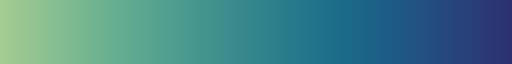

In [3]:
sns.color_palette("crest", as_cmap=True)

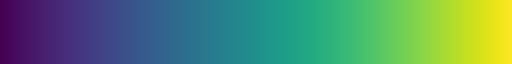

In [4]:
sns.color_palette("viridis", as_cmap=True)